# Deep Energy-Based Generative Models: Complete Tutorial

이 튜토리얼은 딥러닝을 사용한 에너지 기반 생성 모델에 대한 포괄적인 가이드입니다. 이론적 개념과 MNIST 숫자 생성을 위한 실제 구현을 다룹니다.


## 에너지 기반 모델 이론

에너지 기반 모델(Energy-Based Models, EBM)은 확률 분포 $$p(\mathbf{x})$$를 다음과 같이 모델링합니다:

$$q_{\theta}(\mathbf{x}) = \frac{\exp(-E_{\theta}(\mathbf{x}))}{Z_{\theta}}$$

여기서:
- $$E_{\theta}(\mathbf{x})$$: 에너지 함수 (낮은 에너지 = 높은 확률)
- $$Z_{\theta}$$: 정규화 상수 (계산이 어려움)

**핵심 훈련 아이디어: Contrastive Divergence**
- 실제 데이터의 에너지를 낮추고, 생성된 샘플의 에너지를 높임
- 손실 함수: $$E_{\theta}(\mathbf{x}_{\text{sample}}) - E_{\theta}(\mathbf{x}_{\text{train}})$$


In [1]:
# Cell 1
"""
필요한 라이브러리를 임포트하고 환경 설정을 합니다.
학습 시 GPU가 가능하면 자동으로 사용하도록 설정합니다.
"""

import os
import random
import numpy as np
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt

# 학습 재현성 고정
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device in use:", device)

# 체크포인트 저장 폴더
DATASET_PATH = "../data"
CHECKPOINT_PATH = "../saved_models"
os.makedirs(CHECKPOINT_PATH, exist_ok=True)


Device in use: cpu


In [2]:
# Cell 2
"""
MNIST 데이터셋을 불러와서 -1 ~ 1 사이 값으로 정규화 후 DataLoader 구성
"""

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # 0.5 mean / 0.5 std → 범위 -1 ~ 1 근사
])

# 훈련 데이터셋 로드
train_set = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

# 테스트 데이터셋 로드
test_set  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# 데이터 로더 정의
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(test_set,  batch_size=256, shuffle=False, drop_last=False, num_workers=0)

print(f"Train set size: {len(train_set)}")
print(f"Test set size:  {len(test_set)}")
print(f"Train batches:  {len(train_loader)}")


Train set size: 60000
Test set size:  10000
Train batches:  468


In [3]:
# Cell 3
"""
Swish 활성화 함수와 CNN 아키텍처 정의.

- CNN은 28x28 MNIST 숫자를 입력받아 단일 스칼라 출력 (에너지)
- 출력 값은 -E_θ(x)를 의미
"""

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class CNNModel(nn.Module):
    def __init__(self, hidden_features=32, out_dim=1):
        super().__init__()
        c_hid1 = hidden_features // 2
        c_hid2 = hidden_features
        c_hid3 = hidden_features * 2

        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, c_hid1, 5, 2, 2), Swish(),
            nn.Conv2d(c_hid1, c_hid2, 3, 2, 1), Swish(),
            nn.Conv2d(c_hid2, c_hid3, 3, 2, 1), Swish(),
            nn.Conv2d(c_hid3, c_hid3, 3, 2, 1), Swish(),
            nn.Flatten(),
            nn.Linear(c_hid3 * 4, c_hid3), Swish(),
            nn.Linear(c_hid3, out_dim)
        )

    def forward(self, x):
        return self.cnn_layers(x).squeeze(-1)

# 모델 확인
model = CNNModel().to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")


Model parameters: 76,993


Swish 활성화 함수: $x * sigmoid(x)$

ReLU보다 부드러운 그래디언트를 제공하여 에너지 모델에 적합

에너지 기반 모델을 위한 CNN 아키텍처
    
MNIST 28x28 이미지를 입력받아 스칼라 에너지 값을 출력

In [4]:
# Cell 4
"""
샘플링 버퍼와 Langevin Dynamics MCMC 샘플러 구현

- 샘플은 버퍼에서 95%, 새 랜덤 노이즈 5% 혼합하여 초기화 후 샘플링
- generate_samples()가 MCMC를 통해 점진적으로 확률분포에서 샘플링
"""

class Sampler:
    def __init__(self, model, img_shape, sample_size, max_len=8192):
        self.model = model
        self.img_shape = img_shape
        self.sample_size = sample_size
        self.max_len = max_len
        self.examples = [(torch.rand((1,) + img_shape) * 2 - 1) for _ in range(self.sample_size)]

    def sample_new_exmps(self, steps=60, step_size=10):
        n_new = np.random.binomial(self.sample_size, 0.05)
        rand_imgs = torch.rand((n_new,) + self.img_shape) * 2 - 1
        if self.sample_size - n_new > 0:
            old_imgs = torch.cat(random.choices(self.examples, k=self.sample_size - n_new), dim=0)
            inp_imgs = torch.cat([rand_imgs, old_imgs], dim=0).detach().to(device)
        else:
            inp_imgs = rand_imgs.detach().to(device)
        inp_imgs = generate_samples(self.model, inp_imgs, steps=steps, step_size=step_size)
        self.examples = list(inp_imgs.cpu().chunk(self.sample_size, dim=0)) + self.examples
        self.examples = self.examples[:self.max_len]
        return inp_imgs

def generate_samples(model, inp_imgs, steps=60, step_size=10, return_img_per_step=False):
    model.eval()
    for p in model.parameters():
        p.requires_grad = False

    inp_imgs = inp_imgs.clone().detach().to(device)
    inp_imgs.requires_grad_(True)
    
    # 그래디언트 계산 활성화
    had_grad_enabled = torch.is_grad_enabled()
    torch.set_grad_enabled(True)
    
    # 매 반복마다 노이즈 생성을 위한 버퍼 텐서
    noise = torch.randn(inp_imgs.shape, device=inp_imgs.device)
    
    # 각 단계별 생성 이미지 저장용 리스트
    imgs_per_step = []
    
    # K 단계 반복
    for _ in range(steps):
        # 1단계: 입력에 노이즈 추가
        noise.normal_(0, 0.005)
        inp_imgs.data.add_(noise.data)
        inp_imgs.data.clamp_(-1, 1)
        
        # 2단계: 현재 입력에 대한 그래디언트 계산
        # 모델이 -E_θ(x)를 출력하므로 음수를 취함
        out_imgs = -model(inp_imgs)
        out_imgs.sum().backward()
        
        # 안정성을 위한 그래디언트 클리핑
        inp_imgs.grad.data.clamp_(-0.03, 0.03)
        
        # 현재 샘플에 그래디언트 적용 (그래디언트 상승)
        inp_imgs.data.add_(-step_size * inp_imgs.grad.data)
        inp_imgs.grad.detach_()
        inp_imgs.grad.zero_()
        inp_imgs.data.clamp_(-1, 1)

        if return_img_per_step:
            imgs_per_step.append(inp_imgs.clone().detach().cpu())
    
    # 훈련을 위해 파라미터의 그래디언트 재활성화
    for p in model.parameters():
        p.requires_grad = True
    
    # 그래디언트 계산 설정을 원래대로 복원
    torch.set_grad_enabled(had_grad_enabled)
    if return_img_per_step:
        return torch.stack(imgs_per_step, dim=0)
    else:
        return inp_imgs.detach()


에너지 기반 모델을 위한 MCMC 샘플러
    
   Langevin Dynamics를 사용하여 모델에서 샘플링하며,
   
   효율성을 위해 샘플링 버퍼를 유지합니다.

__init__ :

Args:
            
  model: $E_{\theta}$를 모델링하는 신경망
            
   img_shape: 모델링할 이미지 형태
            
  sample_size: 샘플 배치 크기
            
   max_len: 버퍼에 유지할 최대 데이터 포인트 수

sample_new_exmps:

새로운 '가짜' 이미지 배치 생성
        
        Args:
            steps: MCMC 알고리즘 반복 횟수
   step_size: 알고리즘의 학습률 :  $\nu$
            
        Returns:
            생성된 이미지들의 텐서

generate_samples:

주어진 모델에서 이미지 샘플링
        
 Langevin Dynamics MCMC 알고리즘 구현:
        
  $x_t+1 = x_t + step_{size} * ∇_x log p(x_t) + noise$
        
        Args:
            model: E_theta를 모델링하는 신경망
            inp_imgs: 샘플링 시작점이 되는 이미지들
            steps: MCMC 알고리즘 반복 횟수
            step_size: 학습률 nu
            return_img_per_step: True면 모든 단계의 샘플을 반환
            
        Returns:
            최종 생성된 이미지들 (또는 모든 단계의 이미지들)

In [5]:
# Cell 5
"""
학습 중 실시간 로깅과 상태 출력 지원 콜백 구현

- Logger: epoch당 손실값 기록 및 출력
- TableDisplay: 각 배치 끝에 손실값을 깔끔한 표로 출력
- Checkpoint: 특정 조건에서 모델 저장
"""

from IPython.display import display, clear_output
import pandas as pd

class Logger:
    def __init__(self):
        self.epoch_logs = []

    def log_epoch(self, epoch, train_loss, reg_loss, cdiv_loss, duration):
        log_entry = {
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'reg_loss': reg_loss,
            'cdiv_loss': cdiv_loss,
            'epoch_time_sec': duration
        }
        self.epoch_logs.append(log_entry)
        self.display_last_epoch()

    def display_last_epoch(self):
        clear_output(wait=True)
        df = pd.DataFrame(self.epoch_logs)
        display(df.tail(10))

class Checkpoint:
    def __init__(self, save_path, monitor_key='train_loss', mode='min', save_best_only=True):
        self.save_path = save_path
        self.monitor_key = monitor_key
        self.mode = mode
        self.save_best_only = save_best_only
        self.best_value = None

    def step(self, model, logs):
        current = logs[self.monitor_key]
        if self.best_value is None:
            self.best_value = current
            self.save(model)
            print(f"Checkpoint saved (initial).")
        elif self.mode == 'min' and current < self.best_value:
            self.best_value = current
            self.save(model)
            print(f"Checkpoint saved (improved): {self.monitor_key}={current:.4f}")
        elif self.mode == 'max' and current > self.best_value:
            self.best_value = current
            self.save(model)
            print(f"Checkpoint saved (improved): {self.monitor_key}={current:.4f}")

    def save(self, model):
        torch.save(model.state_dict(), self.save_path)


- Logger: epoch당 손실값 기록 및 출력
- TableDisplay: 각 배치 끝에 손실값을 깔끔한 표로 출력
- Checkpoint: 특정 조건에서 모델 저장

In [6]:
# Cell 6
"""
전체 학습 루프: 모델 훈련, 샘플링, 콜백 호출, 실시간 손실 출력

- alpha: 정규화 항 가중치
- optimizer, scheduler 포함
- 훈련 손실, 정규화 손실, contrastive_divergence 손실 출력
"""

def train_energy_model(model, train_loader, sampler, num_epochs=60, lr=1e-4, alpha=0.1):
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.0, 0.999))
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.97)

    logger = Logger()
    checkpoint = Checkpoint(os.path.join(CHECKPOINT_PATH, 'energy_model_best.pt'), monitor_key='train_loss', mode='min')

    for epoch in range(num_epochs):
        model.train()
        start_time = time.time()

        running_loss = 0.0
        running_reg = 0.0
        running_cdiv = 0.0
        total_batches = len(train_loader)

        for batch_idx, (real_imgs, _) in enumerate(train_loader):
            real_imgs = real_imgs.to(device)
            real_imgs = real_imgs + torch.randn_like(real_imgs)*0.005
            real_imgs.clamp_(-1.0, 1.0)

            fake_imgs = sampler.sample_new_exmps(steps=60, step_size=10)

            inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
            real_out, fake_out = model(inp_imgs).chunk(2, dim=0)

            reg_loss = alpha * (real_out.pow(2).mean() + fake_out.pow(2).mean())
            cdiv_loss = fake_out.mean() - real_out.mean()
            loss = reg_loss + cdiv_loss

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()

            running_loss += loss.item()
            running_reg += reg_loss.item()
            running_cdiv += cdiv_loss.item()

            # 배치별 진행상황 출력 (원한다면 활성화)
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{total_batches}, Loss: {loss.item():.4f}")

        scheduler.step()
        epoch_time = time.time() - start_time

        avg_loss = running_loss / total_batches
        avg_reg = running_reg / total_batches
        avg_cdiv = running_cdiv / total_batches

        logger.log_epoch(epoch, avg_loss, avg_reg, avg_cdiv, epoch_time)
        checkpoint.step(model, {'train_loss': avg_loss})

    print("Training complete.")

    # 최종 모델을 로드하여 반환
    model.load_state_dict(torch.load(checkpoint.save_path))
    return model, logger


전체 학습 루프: 모델 훈련, 샘플링, 콜백 호출, 실시간 손실 출력

- alpha: 정규화 항 가중치
- optimizer, scheduler 포함
- 훈련 손실, 정규화 손실, contrastive_divergence 손실 출력

,epoch,train_loss,reg_loss,cdiv_loss,epoch_time_sec
10,11,-0.000252,0.000114,-0.000366,320.220903
11,12,-0.000071,0.000115,-0.000186,313.215052
12,13,-0.000186,0.000118,-0.000304,313.471975
13,14,-0.000044,0.000115,-0.000160,318.205949
14,15,-0.000100,0.000115,-0.000215,316.966824
15,16,-0.000062,0.000101,-0.000163,321.283875
16,17,0.000007,0.000121,-0.000114,327.706785
17,18,-0.000180,0.000112,-0.000292,328.634598
18,19,0.000047,0.000112,-0.000065,333.063569
19,20,-0.000297,0.000125,-0.000422,330.484098


Training complete.


C:\Users\user\anaconda3\envs\test\lib\site-packages\torchvision\utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


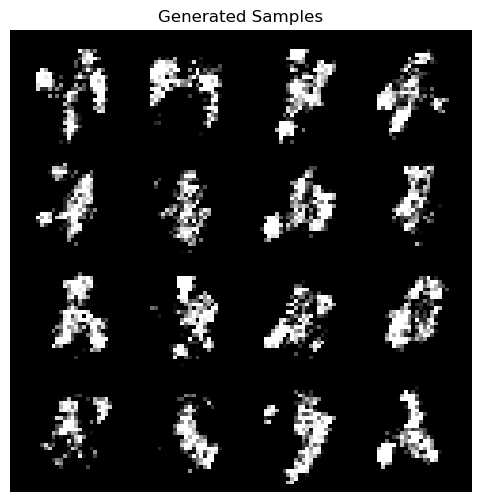

In [7]:
# Cell 7
"""
모델 초기화, 샘플러 생성 후 훈련 시작 및 샘플 생성 결과 시각화
"""

model = CNNModel(hidden_features=32).to(device)
sampler = Sampler(model, img_shape=(1,28,28), sample_size=128)

trained_model, training_logger = train_energy_model(model, train_loader, sampler, num_epochs=20, lr=1e-4, alpha=0.1)


def plot_generated_samples(trained_model, n_samples=16, steps=256):
    trained_model.eval()
    with torch.no_grad():
        start_imgs = torch.rand((n_samples, 1, 28, 28), device=device)*2 - 1
        gen_imgs = generate_samples(trained_model, start_imgs, steps=steps, step_size=10)
    grid = utils.make_grid(gen_imgs.cpu(), nrow=4, normalize=True, range=(-1,1))
    plt.figure(figsize=(6,6))
    plt.imshow(np.transpose(grid.numpy(), (1,2,0)), cmap='gray')
    plt.title("Generated Samples")
    plt.axis('off')
    plt.show()

plot_generated_samples(trained_model)


에너지 기반 모델의 손실값이 음수인 이유는 다음과 같습니다.

1. **손실 함수 구조 — Contrastive Divergence**

   이 모델의 손실은 다음과 같은 구조입니다.

   $$
   \text{loss} = \underbrace{\text{fake\_out.mean()} - \text{real\_out.mean()}}_{\text{contrastive divergence}} + \alpha \times \text{regularization}
   $$

   여기서 `real_out`은 모델이 실제 데이터에 대해 출력하는 값이고, `fake_out`은 가짜 (샘플링된) 데이터에 대한 출력값입니다. 

   모델에서 출력하는 값은 $$-E_\theta(x)$$ (음의 에너지)를 나타냅니다. 에너지는 낮을수록 데이터가 더 잘 들어맞는다는 뜻이고, $$-E_\theta(x)$$는 클수록 데이터 확률이 높다는 의미입니다.

2. **fake_out.mean() - real_out.mean()의 의미**

   - 실제 데이터는 확률이 높아 $$-E_\theta(x)$$ 값이 크고 (즉, $$E_\theta(x)$$는 낮음)
   - 가짜 데이터는 확률이 낮아 $$-E_\theta(x)$$ 값이 작음 (즉, $$E_\theta(x)$$는 높음)

   따라서 이상적인 상황에서는 
   $$
   fake\_out.mean() < real\_out.mean()
   $$
   이므로
   $$
   fake\_out.mean() - real\_out.mean() < 0
   $$

3. **정규화 항 (regularization)**

   정규화 항은 출력값의 제곱 평균으로 음이 될 수 없지만, 보통은 위의 contrastive divergence 손실의 절댓값보다 매우 작아서(가중치 α가 작음) 전체 손실이 음수가 될 수 있습니다.

4. **결과 해석**

   음수 손실값은 “모델이 실제 데이터에 대해 더 높은 확률(낮은 에너지)를 할당하고, 가짜 샘플에 대해서 더 낮은 확률(높은 에너지, 즉 낮은 $$-E_\theta(x)$$)를 할당”하고 있다는 뜻입니다. 즉, 모델이 원하는 방향으로 학습이 잘 되고 있음을 의미합니다.

***

- 출력이 $$-E_\theta(x)$$인 특성상,  
- Contrastive Divergence 손실(fake_out.mean() - real_out.mean()) 자체가 음수라는 것은 정상적입니다.  
- 전체 손실이 음수가 되는 것은 모델이 실제 데이터에 높은 점수(음의 에너지)와 가짜 데이터에 낮은 점수를 잘 할당하고 있다는 좋은 신호입니다.

따라서 학습 중 손실이 음수인 것은 문제나 버그가 아니며, 에너지 모델의 손실 함수 특성상 자연스러운 현상입니다.

Out-of-Distribution Detection:
- 랜덤 노이즈 이미지 평균 에너지 점수: -1.1122 (낮을수록 확률 낮음)
- 실제 훈련 이미지 평균 에너지 점수:   0.0308 (높을수록 확률 높음)
- 점수 차이 (real - noise): 1.1430


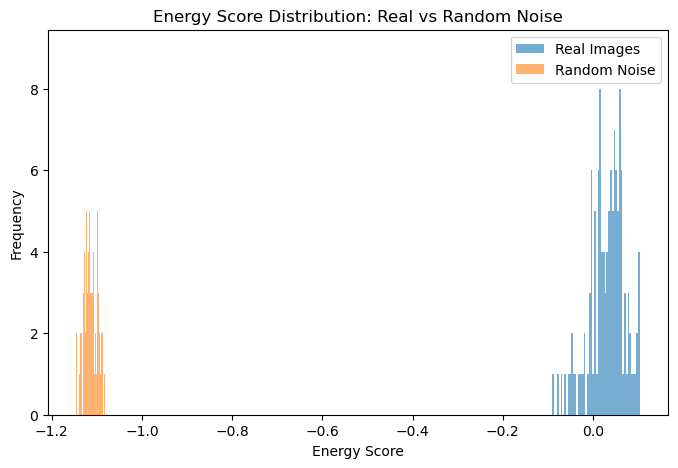

In [8]:
# Cell 8
"""
학습된 에너지 모델을 사용하여 분포 내 데이터와 랜덤 노이즈(분포 외) 데이터에 대한 에너지 점수 비교

- 분포 내 데이터: MNIST 실제 이미지들
- 분포 외 데이터: 랜덤 노이즈 이미지들
"""

def test_out_of_distribution_detection(model, train_loader, device):
    model.eval()
    with torch.no_grad():
        # 랜덤 노이즈 이미지 (분포 외)
        noise_imgs = torch.rand((128, 1, 28, 28), device=device) * 2 - 1
        noise_scores = model(noise_imgs).cpu().numpy()

        # 분포 내 실제 훈련 데이터 일부
        real_imgs, _ = next(iter(train_loader))
        real_imgs = real_imgs.to(device)
        real_scores = model(real_imgs).cpu().numpy()

    print(f"Out-of-Distribution Detection:")
    print(f"- 랜덤 노이즈 이미지 평균 에너지 점수: {noise_scores.mean():.4f} (낮을수록 확률 낮음)")
    print(f"- 실제 훈련 이미지 평균 에너지 점수:   {real_scores.mean():.4f} (높을수록 확률 높음)")
    print(f"- 점수 차이 (real - noise): {real_scores.mean() - noise_scores.mean():.4f}")

    # 히스토그램 시각화
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 5))
    plt.hist(real_scores, bins=50, alpha=0.6, label='Real Images')
    plt.hist(noise_scores, bins=50, alpha=0.6, label='Random Noise')
    plt.xlabel('Energy Score')
    plt.ylabel('Frequency')
    plt.title('Energy Score Distribution: Real vs Random Noise')
    plt.legend()
    plt.show()

# 실행
test_out_of_distribution_detection(trained_model, train_loader, device)


모델이 훈련된 분포 내 실제 이미지에는 상대적으로 높은 점수(낮은 에너지)를 부여하고,

랜덤 노이즈(분포 외)에는 낮은 점수(높은 에너지)를 부여하는지 확인하는 테스트입니다.

분포 내/외 데이터에 대한 점수 차이가 클수록 분포 외 감지 능력이 우수함을 의미합니다.

에너지 점수 분포를 히스토그램으로 시각화하여 분포 차이를 한눈에 볼 수 있습니다.

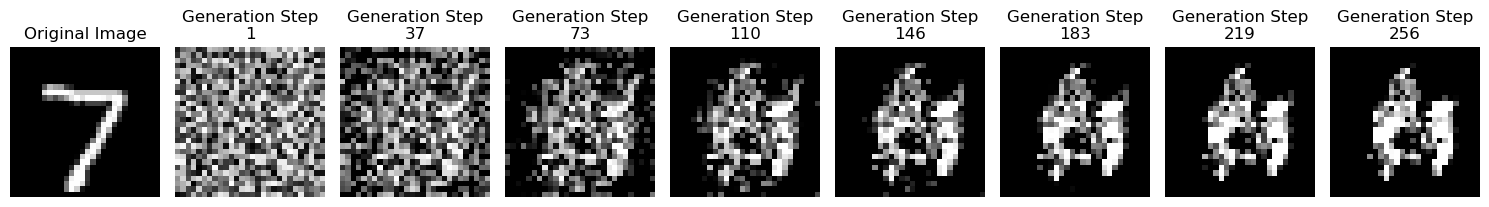

In [12]:
# Cell: 생성 과정 시각화 및 원본과 비교
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def compare_original_and_generation(model, test_loader, device, generation_steps=256, vis_steps=8):
    model.eval()
    with torch.no_grad():
        # 1. 원본 이미지 한 장 선택
        imgs, _ = next(iter(test_loader))
        orig_img = imgs[0].to(device)
        
        # 2. 원본 이미지를 복제하여 MCMC 샘플링 시작점 생성
        start_img = torch.rand((1, 1, 28, 28), device=device) * 2 - 1
        
        # 3. MCMC 생성 과정 샘플 저장
        sampled_images = generate_samples(
            model,
            start_img,
            steps=generation_steps,
            step_size=10,
            return_img_per_step=True
        )  # shape: (steps, batch=1, C, H, W)

    # 시각화를 위해 GPU -> CPU, 텐서 -> numpy 변환
    sampled_images = sampled_images.cpu().squeeze(1)  # (steps, C, H, W)
    orig_img = orig_img.cpu().squeeze(0)  # (H, W)

    # 시각화: 원본 + generation 과정 일부 단계 표시
    plt.figure(figsize=(15, 4))
    
    # 0번째 화면: 원본 이미지
    plt.subplot(1, vis_steps+1, 1)
    plt.imshow(orig_img, cmap='gray', vmin=-1, vmax=1)
    plt.title("Original Image")
    plt.axis('off')

    steps_indices = np.linspace(0, generation_steps-1, vis_steps, dtype=int)
    for i, step_idx in enumerate(steps_indices, start=2):
        plt.subplot(1, vis_steps+1, i)
        plt.imshow(sampled_images[step_idx].squeeze(0), cmap='gray', vmin=-1, vmax=1)
        plt.title(f"Generation Step\n{step_idx + 1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# 실행 예시:
compare_original_and_generation(trained_model, test_loader, device, generation_steps=256, vis_steps=8)


분포 외 감지는 잘 작동 → 모델은 확률 분포 구분 가능

이미지 생성 실패 → 모델 표현력 및 샘플링 수렴 문제, 학습량 부족 복합 원인

개선을 위해 아키텍처 확장, 학습 증대, 샘플링 강화, 하이퍼파라미터 최적화 필요

에너지 기반 생성 모델은 훈련과 샘플링 과정이 매우 어렵고 불안정함

특히 MCMC (Langevin Dynamics) 샘플링이 충분히 수렴하지 않으면 노이즈나 의미 없는 패턴을 생성함

20 epoch 학습은 비교적 짧은 편임 → 모델의 복잡한 분포를 제대로 학습하기 어려움